In [47]:
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import time
import pylab as pl
from IPython import display

#from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

In [30]:
class GBM:
    
    def __init__(self, numDimensions, startValue, mu, sigma, nSteps, corr):
        self.numDimensions = numDimensions
        self.mu = [0] * numDimensions
        self.sigma = [0] * numDimensions
        self.prevValue = [0] * numDimensions
        tempShiftArray = [0] * numDimensions

        self.nSteps = nSteps
        self.corr = corr
        self.step = 1
        self.deltaT = 1.0 / nSteps
        self.dimChanged = 0

        for i in range(numDimensions):
            self.prevValue[i] = startValue
            self.mu[i] = mu
            self.sigma[i] = sigma
            
        np.random.seed()
            

    def generateNextRandom(self):
        R = [0] * self.numDimensions
        R[0] = np.random.normal()
        self.prevValue[0] += self.prevValue[0] * (self.mu[0] * self.deltaT + self.sigma[0] * np.sqrt(self.deltaT) * R[0])
        
        for i in range(1, self.numDimensions):
            tempR = np.random.normal()
            R[i] = self.corr * R[0] + np.sqrt(1 - self.corr * self.corr) * tempR
            self.prevValue[i] += self.prevValue[i] * (self.mu[i] * self.deltaT + self.sigma[i] * np.sqrt(self.deltaT) * R[i])

        self.step += 1
        
        return self.prevValue


In [3]:
class ATickM:

    def __init__(self, bid = None, ask = None, time = None):
        self.bid = bid
        self.ask = ask
        self.time = time

        
    def getBid(self):
        return self.bid

    
    def getAsk(self):
        return self.ask
    

    def getMid(self):
        midArray = [0] * len(self.bid)
        
        for i in range(len(self.bid)):
            midArray[i] = ( self.bid[i] + self.ask[i] ) / 2.0
        
        return midArray
    

    def getTime(self):
        return self.time
    

    def clone(self):
        return ATickM(self.bid, self.ask, self.time)
    

    def normalize(self, referenceTick):
        normMid = referenceTick.getMid()
        
        for i in range(len(normMid)):
            self.bid[i] /= normMid[i]
            self.ask[i] /= normMid[i]


In [150]:
class RunnerM:

    def __init__(self, delta):
        self.delta = delta
        self.osL = 0
        self.initialized = False
        self.firstPrice = True
        self.extSurf = None
        self.prevExtreme = None
        self.count = 0
        self.timeExtreme = 0
        self.timePrevExtreme = 0
        self.osMultiple = 0
    

    def run(self, aTickM):
        aPrice = aTickM.getMid()[:]
        
        if not self.initialized:
            
            if self.firstPrice:
                self.extreme = aPrice[:]
                self.timeExtreme = aTickM.getTime()
                self.firstPrice = False
            
            if self.getDistance(aPrice, self.extreme) >= self.delta:
                self.mode = (1 if aPrice[0] >= self.extreme[0] else -1) # the first element in the array (the first rate) defines the mode
                self.prevExtreme = self.extreme[:]
                self.timePrevExtreme = self.timeExtreme

                self.prevDC = aPrice[:]
                self.extreme = aPrice[:]
                self.timeExtreme = aTickM.getTime()
                self.prevExtDCLine = self.lineVector(self.prevExtreme, self.prevDC)
                self.extSurf = self.surfCoef(self.prevExtDCLine, aPrice)
                self.initialized = True
                return self.mode

        else:
            self.newExtreme = False
            self.newExtreme = (self.diffSides(self.extSurf, self.prevExtreme, aPrice))

            if (self.newExtreme):
                self.extSurf = self.surfCoef(self.prevExtDCLine, aPrice)
                self.extreme = aPrice[:]
                self.timeExtreme = aTickM.getTime()
                overS = self.getDistance(self.projPointSurf(self.extSurf, self.prevDC), self.prevDC)
                if (np.floor(overS / self.delta) > self.osMultiple):
                    self.osMultiple = np.floor(overS / self.delta)
                    return self.mode * 2 # new OS intrinsic event
                else:
                    return 0

            else:
                self.newDC = False
                self.newDC = (self.getDistance(aPrice, self.projPointSurf(self.extSurf, aPrice)) >= self.delta)

                if (self.newDC):
                    self.osL = self.getDistance(self.projPointSurf(self.extSurf, self.prevDC), self.prevDC)

                    if (self.osL > 0.5):
                        print "Collapse!" # TODO: why collapse?

                    self.prevExtreme = self.extreme[:]
                    self.timePrevExtreme = self.timeExtreme
                    self.extreme = aPrice[:]
                    self.timeExtreme = aTickM.getTime()
                    self.prevExtDCLine = self.lineVector(self.prevExtreme, aPrice)
                    self.extSurf = self.surfCoef(self.prevExtDCLine, aPrice)
                    self.prevDC = aPrice[:]
                    self.mode = -self.mode
                    self.osMultiple = 0
                    return self.mode
        
        return 0
  
 
        
    def getDistance(self, array1, array2):
        Sum = 0
        
        for i in range(len(array1)):
            Sum += np.power((array1[i] - array2[i]) / array2[i], 2)
        
        return np.sqrt(Sum)
    

    def lineVector(self, pointA, pointB):
        vector = [0] * len(pointA)
        
        for i in range(len(pointA)):
            vector[i] = pointB[i] - pointA[i]
        
        return vector
    

    def surfCoef(self, lineVector, pointToGoThrough):
        surfCoef = [0] * (len(lineVector) + 1)
        lastCoef = 0
        
        for i in range(len(lineVector)):
            surfCoef[i] = lineVector[i]
            lastCoef += lineVector[i] * pointToGoThrough[i]
        
        surfCoef[len(surfCoef) - 1] = -lastCoef
        
        return surfCoef
        
        
    def distSurfPoint(self, surfCoef, point):
        projPoint = self.projPointSurf(surfCoef, point)
        
        return self.getDistance(projPoint, point)


    def diffSides(self, surfCoef, pointA, pointB):
        valA = 0
        valB = 0
        
        for i in range(len(pointA)):
            valA += surfCoef[i] * pointA[i]
            valB += surfCoef[i] * pointB[i]
        
        valA += surfCoef[len(surfCoef) - 1]
        valB += surfCoef[len(surfCoef) - 1]
        
        return (valA * valB < 0)


    def projPointSurf(self, surfCoef, point):
        projection = [0] * len(point)
        upPart = 0
        botPart = 0

        for i in range(len(point)):
            upPart += surfCoef[i] * point[i]
            botPart += np.power(surfCoef[i], 2)
        

        upPart += surfCoef[len(surfCoef) - 1]
        lamb = upPart / botPart

        for i in range(len(point)):
            projection[i] = point[i] - lamb * surfCoef[i]
        
        return projection

In [151]:
def oneDimGBMdCiEPlot(numSteps, startVal, mu, sigma, delta):
    gbm = GBM(1, startVal, mu, sigma, numSteps, 0)
    runnerM = RunnerM(delta)

    # timeStamp + value for the plot
    priceChanges = [[],[]]
    dcIEvents = [[],[]]
    osIEvents = [[],[]]
    extremes = [[],[]]

    for i in range(numSteps):
        generatedValues = gbm.generateNextRandom()
        aTickM = ATickM(generatedValues, generatedValues, i)
        ie = runnerM.run(aTickM)

        priceChanges[0].append(i)
        priceChanges[1].append(generatedValues[0])

        if (abs(ie) == 1):
            dcIEvents[0].append(i)
            dcIEvents[1].append(generatedValues[0])
            extremes[0].append(runnerM.timePrevExtreme)
            extremes[1].append(runnerM.prevExtreme[0])
            
        if (abs(ie) == 2):
            osIEvents[0].append(i)
            osIEvents[1].append(generatedValues[0])

            
    dcSections = []
    for i in range(len(extremes[0])):
        dcSections.append([(extremes[0][i], extremes[1][i]), (dcIEvents[0][i], dcIEvents[1][i])])
    dcC = mc.LineCollection(dcSections, linewidths=2, color="black", alpha=0.8)

    osSections = []
    for i in range(len(dcIEvents[0]) - 1):
        osSections.append([(dcIEvents[0][i], dcIEvents[1][i]), (extremes[0][i + 1], extremes[1][i + 1])]) 
    osC = mc.LineCollection(osSections, linewidths=2, color="black", linestyles="--", alpha=0.8)

    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(priceChanges[0], priceChanges[1], color="black", alpha=0.5, linewidth=1)
    ax.add_collection(dcC)
    ax.add_collection(osC)
    ax.scatter(dcIEvents[0], dcIEvents[1], facecolors='none', edgecolors='black', linewidth=3, marker="s", s=100, alpha=0.8, label="DC IE")
    ax.scatter(osIEvents[0], osIEvents[1], facecolors='none', edgecolors='red', linewidth=3, marker="o", s=50, alpha=0.8, label="OS IE")
    ax.scatter(extremes[0], extremes[1], facecolors='none', edgecolors='black', linewidth=3, marker="o", s=100, alpha=0.8, label="Extreme")
    
    plt.title('1D DC IT', fontsize="xx-large")
    plt.legend(loc=1)
    plt.xlabel('Time', fontsize="xx-large")
    plt.ylabel('Price', fontsize="xx-large")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=8)
    #plt.savefig('osLength_%r.pdf' %i, bbox_inches='tight')
    plt.show()

    i += 1

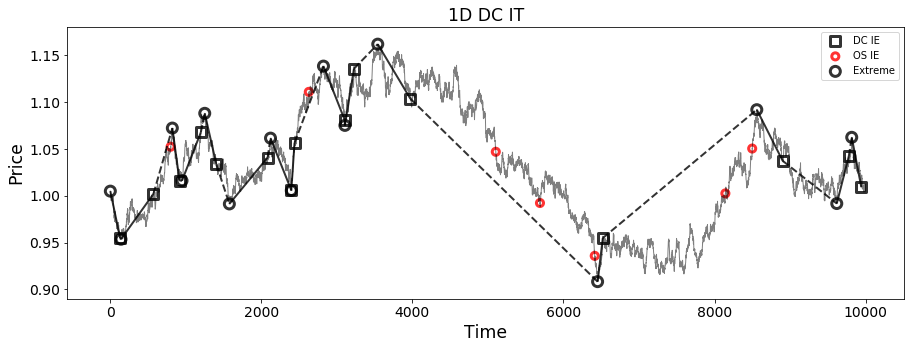

In [152]:
oneDimGBMdCiEPlot(10000, 1.0, 0.2, 0.2, 0.05)

In [6]:
def ClosestPointOnLine(a, b, p):
    ap = p - a
    ab = b - a
    result = a + np.dot(ap,ab) / np.dot(ab,ab) * ab
    return result

In [129]:
def twoDimGBMdCiEPlot(numSteps, startVal, mu, sigma, delta, corr):
    gbm = GBM(2, startVal, mu, sigma, numSteps, corr)
    runnerM = RunnerM(delta)

    # timeStamp + value for the plot
    priceChanges = [[],[],[]]
    dcIEvents = [[],[],[]]
    osIEvents = [[],[],[]]
    extremes = [[],[],[]]

    for i in range(numSteps):
        generatedValues = gbm.generateNextRandom()
        aTickM = ATickM(generatedValues, generatedValues, i)
        ie = runnerM.run(aTickM)

        priceChanges[0].append(i)
        priceChanges[1].append(generatedValues[0])
        priceChanges[2].append(generatedValues[1])


        if (abs(ie) == 1):
            dcIEvents[0].append(i)
            dcIEvents[1].append(generatedValues[0])
            dcIEvents[2].append(generatedValues[1])
            extremes[0].append(runnerM.timePrevExtreme)
            extremes[1].append(runnerM.prevExtreme[0])
            extremes[2].append(runnerM.prevExtreme[1])
            
        if (abs(ie) == 2):
            osIEvents[0].append(i)
            osIEvents[1].append(generatedValues[0])
            osIEvents[2].append(generatedValues[1])

            
    dcSections = []
    for i in range(len(extremes[0])):
        dcSections.append([(extremes[1][i], extremes[2][i]), (dcIEvents[1][i], dcIEvents[2][i])])
    dcC = mc.LineCollection(dcSections, linewidths=2, color="black", alpha=0.8)

    osSections = []
    for i in range(len(dcIEvents[0]) - 1):
        normToBoard = ClosestPointOnLine(np.array([extremes[1][i], extremes[2][i]]),
                                         np.array([dcIEvents[1][i], dcIEvents[2][i]]), np.array([extremes[1][i + 1],
                                                                                             extremes[2][i + 1]]))
        osSections.append([(dcIEvents[1][i], dcIEvents[2][i]), (normToBoard[0], normToBoard[1])]) 
    osC = mc.LineCollection(osSections, linewidths=2, color="black", linestyles="--", alpha=0.8)
    
    borderSections = []
    for i in range(len(dcIEvents[0]) - 1):
        normToBoard = ClosestPointOnLine(np.array([extremes[1][i], extremes[2][i]]),
                                         np.array([dcIEvents[1][i], dcIEvents[2][i]]), np.array([extremes[1][i + 1],
                                                                                             extremes[2][i + 1]]))
        borderSections.append([(normToBoard[0], normToBoard[1]), (extremes[1][i + 1], extremes[2][i + 1])]) 
    borderC = mc.LineCollection(borderSections, linewidths=2, color="red", linestyles="--", alpha=0.6)

    fig, ax = plt.subplots(figsize = (10,10))
    ax.plot(priceChanges[1], priceChanges[2], color="black", alpha=0.5, linewidth=1)
    ax.add_collection(dcC)
    ax.add_collection(osC)
    ax.add_collection(borderC)
    ax.scatter(dcIEvents[1], dcIEvents[2], facecolors='none', edgecolors='black', linewidth=3, marker="s", s=100, alpha=0.8)
    ax.scatter(osIEvents[1], osIEvents[2], facecolors='none', edgecolors='red', linewidth=3, marker="o", s=50, alpha=0.8)
    ax.scatter(extremes[1], extremes[2], facecolors='none', edgecolors='black', linewidth=3, marker="o", s=100, alpha=0.8)
    
    plt.title('2D DC IT', fontsize="xx-large")
    plt.xlabel('Price 1', fontsize="xx-large")
    plt.ylabel('Price 2', fontsize="xx-large")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=8)
    plt.axis('equal')
    #plt.savefig('osLength_%r.pdf' %i, bbox_inches='tight')
    plt.show()

    i += 1

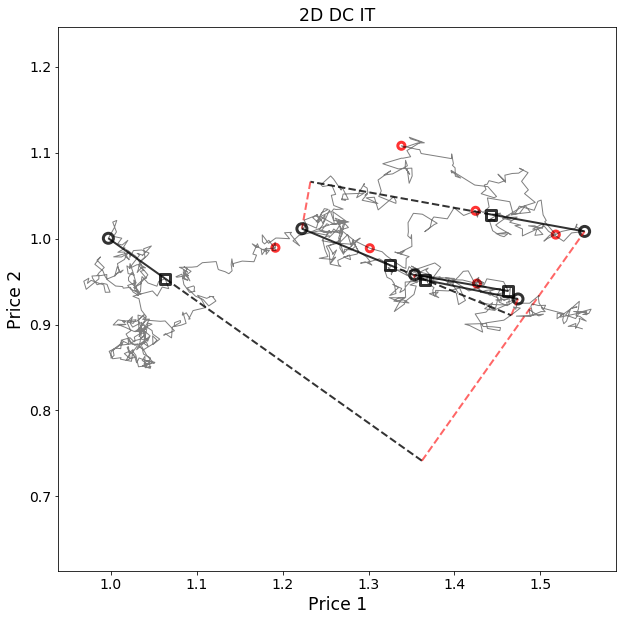

In [137]:
twoDimGBMdCiEPlot(1000, 1.0, 0, 0.2, 0.08, 0)

In [138]:
def threeDimGBMdCiEPlot(numSteps, startVal, mu, sigma, delta, corr):
    gbm = GBM(3, startVal, mu, sigma, numSteps, corr)
    runnerM = RunnerM(delta)

    # timeStamp + value for the plot
    priceChanges = [[],[],[],[]]
    dcIEvents = [[],[],[],[]]
    osIEvents = [[],[],[],[]]
    extremes = [[],[],[],[]]

    for i in range(numSteps):
        generatedValues = gbm.generateNextRandom()
        aTickM = ATickM(generatedValues, generatedValues, i)
        ie = runnerM.run(aTickM)

        priceChanges[0].append(i)
        priceChanges[1].append(generatedValues[0])
        priceChanges[2].append(generatedValues[1])
        priceChanges[3].append(generatedValues[2])


        if (abs(ie) == 1):
            dcIEvents[0].append(i)
            dcIEvents[1].append(generatedValues[0])
            dcIEvents[2].append(generatedValues[1])
            dcIEvents[3].append(generatedValues[2])
            extremes[0].append(runnerM.timePrevExtreme)
            extremes[1].append(runnerM.prevExtreme[0])
            extremes[2].append(runnerM.prevExtreme[1])
            extremes[3].append(runnerM.prevExtreme[2])
            
        if (abs(ie) == 2):
            osIEvents[0].append(i)
            osIEvents[1].append(generatedValues[0])
            osIEvents[2].append(generatedValues[1])
            osIEvents[3].append(generatedValues[2])

            
    dcSections = []
    for i in range(len(extremes[0])):
        dcSections.append([(extremes[1][i], extremes[2][i], extremes[3][i]), (dcIEvents[1][i], dcIEvents[2][i], dcIEvents[3][i])])
    dcC = Line3DCollection(dcSections, linewidths=2, color="black", alpha=0.8)

    osSections = []
    for i in range(len(dcIEvents[0]) - 1):
        normToBoard = ClosestPointOnLine(np.array([extremes[1][i], extremes[2][i], extremes[3][i]]),
                                         np.array([dcIEvents[1][i], dcIEvents[2][i], dcIEvents[3][i]]),
                                         np.array([extremes[1][i + 1], extremes[2][i + 1], extremes[3][i + 1]]))
        osSections.append([(dcIEvents[1][i], dcIEvents[2][i], dcIEvents[3][i]), (normToBoard[0], normToBoard[1], normToBoard[2])]) 
    osC = Line3DCollection(osSections, linewidths=2, color="black", linestyles="--", alpha=0.8)
    
    borderSections = []
    for i in range(len(dcIEvents[0]) - 1):
        normToBoard = ClosestPointOnLine(np.array([extremes[1][i], extremes[2][i], extremes[3][i]]),
                                         np.array([dcIEvents[1][i], dcIEvents[2][i], dcIEvents[3][i]]),
                                         np.array([extremes[1][i + 1], extremes[2][i + 1], extremes[3][i + 1]]))
        borderSections.append([(normToBoard[0], normToBoard[1], normToBoard[2]), (extremes[1][i + 1], extremes[2][i + 1], extremes[3][i + 1])]) 
    borderC = Line3DCollection(borderSections, linewidths=2, color="red", linestyles="--", alpha=0.6)
          
    fig, ax = plt.subplots(figsize = (15,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(priceChanges[1], priceChanges[2], priceChanges[3], color="black", alpha=0.5, linewidth=1)
    ax.add_collection(dcC)
    ax.add_collection(osC)
    ax.add_collection(borderC)
    ax.scatter(dcIEvents[1], dcIEvents[2], dcIEvents[3], facecolors='none', edgecolors='black', linewidth=1, marker="s", s=100, alpha=0.8)
    ax.scatter(osIEvents[1], osIEvents[2], osIEvents[3], facecolors='none', edgecolors='red', linewidth=1, marker="o", s=50, alpha=0.8)
    ax.scatter(extremes[1], extremes[2], extremes[3], facecolors='none', edgecolors='black', linewidth=3, marker="o", s=100, alpha=0.8)
    
    plt.title('3D DC IT', fontsize="xx-large")
    ax.set_xlabel('Price 1', fontsize="xx-large", labelpad=10)
    ax.set_ylabel('Price 2', fontsize="xx-large", labelpad=10)
    ax.set_zlabel('Price 3', fontsize="xx-large", labelpad=10)
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=8)
    plt.axis('equal')
    #plt.savefig('osLength_%r.pdf' %i, bbox_inches='tight')
    plt.show()

    i += 1

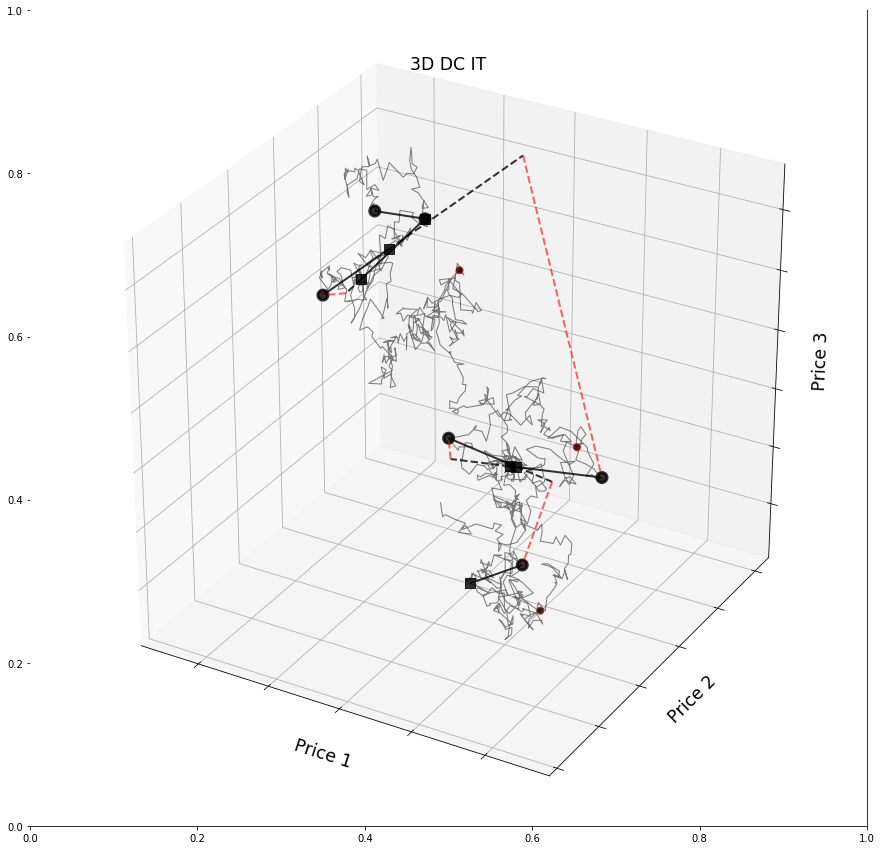

In [139]:
threeDimGBMdCiEPlot(1000, 1.0, 0, 0.2, 0.08, 0)